<!-- # Elastoplastic SDOF system -->

> March 2020, By Amir Hossein Namadchi

This is an OpenSeesPy simulation of a simple SDOF system with elastoplastic behavior mentioned in *Dynamics of Structures* book by  *Ray W. Clough* and *J. Penzien*. This example has been solved in the book, so the result obtained here can be compared with the reference.

> This notebook is adapted from https://github.com/AmirHosseinNamadchi/OpenSeesPy-Examples/blob/master/Elastoplastic%20SDOF%20system.ipynb

![EPSDOF](SDOFElastoPlastic.png)

In [1]:
import numpy as np
import opensees.openseespy as ops
import matplotlib.pyplot as plt

In [2]:
## Units
inch = 1              # inches
kips = 1              # KiloPounds
sec = 1               # Seconds

lb = kips*(sec**2)/inch    # mass unit (derived)

Model specifications are defined as follows:

In [3]:
m = 0.1*lb              # Mass
k = 5.0*(kips/inch)     # Stiffness
c = 0.2*(kips*sec/inch) # Damping
dy_p = 1.2*inch         # Plastic state displacment
alpha_m = c/m           # Rayleigh damping ratio

# Variation of p(t) in tabular form
load_history = np.array([[0,   0],
                         [0.1, 5],
                         [0.2, 8],
                         [0.3, 7],
                         [0.4, 5],
                         [0.5, 3],
                         [0.6, 2],
                         [0.7, 1],
                         [0.8, 0]])

# Dynamic Analysis Parameters
dt = 0.01
time = 1.0

### Analysis
Let's wrap the whole part in a function so that different material behavior could be passed to the function:

In [4]:
def do_analysis(dt, time, material_params):
    
    model = ops.Model(ndm=1, ndf=1)
    time_domain = np.arange(0, time, dt)

    # Nodes
    model.node(1,0.0,0.0)
    model.node(2,0.0,0.0)

    model.uniaxialMaterial(*material_params)
    model.element('ZeroLength', 1, *[1,2], mat=1, dir=1)
    model.mass(2, m)
    model.rayleigh(alpha_m, 0.0, 0.0, 0.0)

    model.fix(1,1)
    model.timeSeries('Path', 1,
                     values=load_history[:,1],
                     time=load_history[:,0])
    
    model.pattern('Plain', 1, 1)
    model.load(2, 1)
    
    # Analysis
    model.constraints('Plain')
    model.numberer('Plain')
    model.system('ProfileSPD')
    model.test('NormUnbalance', 0.0000001, 100)
    model.algorithm('ModifiedNewton')
    model.integrator('Newmark', 0.5, 0.25)
    model.analysis('Transient')
    
    time_lst =[0]           # list to hold time stations for plotting
    response = [0]          # response params of node 2     
    

    for i in range(len(time_domain)):
        model.analyze(1, dt)
        time_lst.append(model.getTime())
        response.append(model.nodeDisp(2,1))
    
    return {'time_list':np.array(time_lst),
            'd': np.array(response)}


For comparison (similar to the book), elastic analysis is also inculded:

In [5]:
epp = do_analysis(dt, time, ['ElasticPP', 1, k, dy_p])     # Elastic-Perfectly Plastic
els = do_analysis(dt, time, ['Elastic', 1, k])             # Elastic

### Visualization

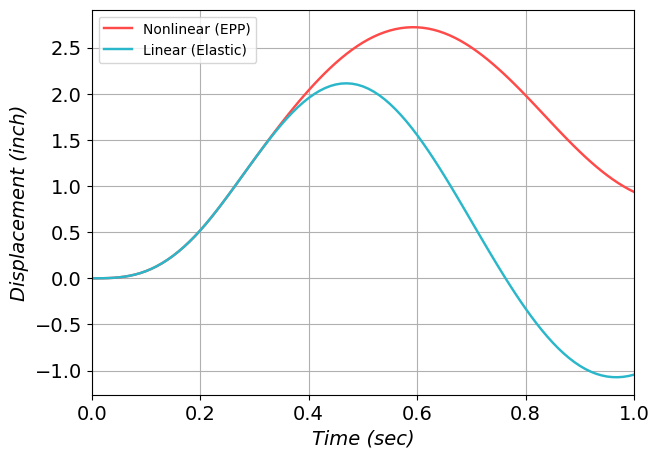

In [6]:
plt.figure(figsize=(7,5))
plt.plot(epp['time_list'], epp['d'], color = '#fe4a49', linewidth=1.75, label = 'Nonlinear (EPP)')
plt.plot(els['time_list'], els['d'], color = '#2ab7ca', linewidth=1.75, label = 'Linear (Elastic)')
plt.ylabel('Displacement (inch)', {'fontstyle':'italic','size':14})
plt.xlabel('Time (sec)', {'fontstyle':'italic','size':14})
plt.xlim([0.0, time])
plt.legend()
plt.grid()
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14);

### Closure
Results obtained here with OpenSees perfectly agree with the ones in the book.

### References
- <blockquote>Clough, R.W. and Penzien, J., 2003. Dynamics of structures. Berkeley. CA: Computers and Structures, Inc.
</blockquote>